<a href="https://colab.research.google.com/github/rsekhar-vai/nlptc/blob/master/TextClassification_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup the Environment

In [0]:
%load_ext autoreload

In [0]:
!rm -r nlptc
!git clone https://github.com/rsekhar-vai/nlptc.git

Cloning into 'nlptc'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 138 (delta 66), reused 43 (delta 15), pack-reused 0
Receiving objects: 100% (138/138), 3.64 MiB | 3.88 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [0]:
!ls nlptc -R

nlptc:
 data	       models.py				   utilclasses.py
 __init__.py   README.md				   utilfunctions.py
'Model Repo'   TextClassification_Jupyter_Notebook.ipynb

nlptc/data:
init  news.csv	sample_submission.csv  test.csv  train.csv

'nlptc/Model Repo':
CharCNN_Simple.py  ConvRec_BiLSTM.py  __init__.py  VDCNN.py


In [0]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sys
import spacy
import torchtext
from torchtext import data
from torchtext.data import Field, BucketIterator
from torchtext import vocab


print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)


Python version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Pandas version: 1.0.3
Pytorch version: 1.4.0
Torch Text version: 0.3.1
Spacy version: 2.2.4


In [0]:
  args = Namespace(
      text_csv="nlptc/data/news.csv",
      train_csv="nlptc/data/train.csv",
      val_csv="nlptc/data/val.csv",
      test_csv="nlptc/data/test.csv",
      model_state_file="model.pth",
      save_dir="model_storage/Clf",
      glove_filepath='D:\\Projects\\Text Analytics\\Glove\\glove.6B.100d.txt',
      hidden_dim=100,
      num_channels=100,
      seed=1337,
      learning_rate=0.001,
      dropout_p=0.1,
      batch_size=64,
      num_epochs=20,
      early_stopping_criteria=5,
      cuda=True,
      catch_keyboard_interrupt=True,
      reload_from_files=False,
      expand_filepaths_to_save_dir=True,
      token_type = 'w',
      max_text_length = 256,
      pretrained_embeddings= 'Glove',
      embedding_size=100,
  )

In [0]:
from nlptc.utilclasses import *
from nlptc.utilfunctions import *

setup_environment(args)


Expanded filepaths: 
	model_storage/Clf/vectorizer.json
	model_storage/Clf/model.pth
Using CUDA: True


# Read Data file and split into Train, Validation and Test
Text data file should have columns named as 'text' and 'category'. If the names are different, they should be renamed before processing further

In [0]:
dataframe_data = pd.read_csv(args.text_csv)
        
max_text_length = 256,
args.token_type = 'w'
#text_df = pd.read_csv(args.text_csv)
text_df_orig = pd.read_csv(args.text_csv)
print(text_df_orig.columns)

text_df_orig.rename(columns={'title':'text'},inplace=True)
text_df = text_df_orig[['text','category']] 
print(text_df.columns)

dataset = TextDataset(text_df,args)
train_df, val_df, test_df = dataset.get_splits()

train_df.to_csv(args.train_csv, index=False)
val_df.to_csv(args.val_csv, index=False)
test_df.to_csv(args.test_csv, index=False)


Index(['title', 'category'], dtype='object')
Index(['text', 'category'], dtype='object')


In [0]:
train_df.head()

,text,category
83622,Iran Says Preliminary Nuclear Deal Reached wit...,World
71641,"Powell, Japan #39;s Machimura Discuss Iraq, Af...",World
34791,China grabs software research deals despite risks,Sci/Tech
9430,Williams-Sonoma Profit Up; Keeps Forecast (Reu...,Business
116739,HIH inquiry claims its biggest scalp,Business


# Define TorchText Fields Variables and map them to Data file Columns
TEXT variable maps to the text we will process. LABEL variable maps to Category associated with the TEXT.

TEXT and LABEL are of type FIELD which is part of TorchText package. FIELD comes with many built in functions that help in simplifying proprocessing. For example we can pass tokenizer as the argument to TEXT. Using this, TorchText does automatic tokenization while parsing the Text File Columns




In [0]:
nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser", "ner"])

def tokenizer(sentence):
    tokens = [w.text.lower() for w in nlp(clean_text(sentence))]
    return tokens

In [0]:
Field_TEXT = data.Field(tokenize=tokenizer, sequential=True, 
                        use_vocab=True,batch_first=True,fix_length=args.max_text_length)
Field_LABEL = data.LabelField(sequential=False)
mapping_with_file_columns = [('text', Field_TEXT), ('category', Field_LABEL)]


# Create TorchText Dataset wrappers around Train, Validation and Test Data files using the TorchText Field Variables
TorchText Dataset is a wrapper around a normal data file. It comes with many build in functions that help simplify processing. Dataset wrapper needs the mapping between TorchText Fields and data file columns (as defined in the previous step) 

In [0]:
 Dataset_train, Dataset_val, Dataset_test = data.TabularDataset.splits(
                                         path = '',
                                         train = args.train_csv,
                                         validation = args.val_csv,
                                         test = args.test_csv,
                                           format = 'csv',
                                         fields = mapping_with_file_columns,
                                         skip_header = True
     )
print(vars(Dataset_train[0]))


{'text': ['iran', 'says', 'preliminary', 'nuclear', 'deal', 'reached', 'with', 'eu'], 'category': 'World'}


# Build Vocabulary and Word Vectors using the Datasets Created

Volcabulary is list of unique Tokens in the text data. We will map each of the unique tokens to Word Vectors (or embeddings) using Glove Database

In [0]:
 %%time
MAX_VOCAB_SIZE = 25000
#vec = vocab.Vectors('glove.6B.100d.txt', 'D:/qBots/nlptc/glove_embedding/')
Field_TEXT.build_vocab(Dataset_train,Dataset_val,
                  max_size = MAX_VOCAB_SIZE, 
                  vectors = "glove.6B.100d", 
##                vectors = vec,
                  unk_init = torch.Tensor.normal_)
Field_LABEL.build_vocab(Dataset_train)


CPU times: user 843 ms, sys: 141 ms, total: 984 ms
Wall time: 986 ms


In [0]:
Field_TEXT.vocab.vectors.shape

torch.Size([25002, 100])

In [0]:
Field_TEXT.vocab.vectors[Field_TEXT.vocab.stoi['testing']]

tensor([ 0.1258,  0.2037, -0.1123,  0.3045, -0.9769, -0.5542,  0.4286,  0.7928,
        -0.7157,  0.7587, -0.1077, -0.3529,  0.0333, -0.0764,  0.3469,  0.2451,
         0.5385,  0.7100,  0.0522, -0.1323, -0.4734, -0.1800,  0.1982, -0.0651,
        -0.4349,  0.4343, -0.0951, -0.3966, -0.4798,  0.4940, -0.3679,  0.2031,
        -0.3497,  0.2970,  1.0122,  0.0933, -0.3492, -0.4592, -0.8168,  0.0374,
        -0.8714, -0.1617, -0.0595, -0.4740, -0.3519,  0.2339,  0.4807, -0.6236,
        -0.3462, -0.7426,  0.8620,  0.0581, -0.8875,  0.8843,  0.0444, -1.3311,
        -0.7529,  0.0039,  1.9239, -0.0039,  0.2040,  0.3463,  0.9224,  0.5198,
         0.4460,  0.6641, -0.2858, -0.2286,  0.1590,  0.1543, -0.0106,  0.5443,
        -0.1647,  0.2509, -0.1672,  0.4843,  0.4626, -0.4024, -1.2572, -0.2214,
         0.6287, -0.2696, -0.5828,  0.2838, -1.7209,  0.6726,  0.8789,  0.3482,
        -0.9895,  0.4533, -0.5951,  0.0075,  0.0057,  0.5793,  0.6368,  0.5939,
        -0.1434, -0.2136,  0.4768,  0.39

In [0]:
print(Field_LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7ffa7a1a8f28>, {'Sci/Tech': 0, 'World': 1, 'Business': 2, 'Sports': 3})


In [0]:
embeddings = Field_TEXT.vocab.vectors.numpy()


# Create the Torchtext Batches as wrapper around Dataset_train/val/test for iterating over during Training/Validation/Testng

In [0]:
BATCH_SIZE = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Batches_train, Batches_val, Batches_test = data.BucketIterator.splits(
    (Dataset_train, Dataset_val,Dataset_test), 
    batch_size = args.batch_size,
    sort_key=lambda x: len(x.text), 
    sort_within_batch=True, 
    device = device)

print("***** Number of Train and Validation batches are :",len(Batches_train), len(Batches_val))


***** Number of Train and Validation batches are : 1055 352


In [0]:
batch = next(iter(Batches_train))

In [0]:
batch.category.shape

torch.Size([64])

In [0]:
batch.text.shape

torch.Size([64, 256])

In [0]:
def idxtosent(batch, idx):
    return ' '.join([Field_TEXT.vocab.itos[i] for i in batch.text[idx,:].cpu().data.numpy()])

In [0]:
for i in range(2):
  print(idxtosent(batch,i))

ferdinand can benefit from winds of change <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

# Build a Neural Network (Simple Word CNN)

In [0]:
from nlptc.models import *

In [0]:
embeddings = Field_TEXT.vocab.vectors.numpy()
type(embeddings)

numpy.ndarray

In [0]:
classifier = WordCNN_Simple(embedding_size=args.embedding_size,
                                    num_embeddings=len(Field_TEXT.vocab),
                                    num_channels=args.num_channels,
                                    hidden_dim=args.hidden_dim,
                                    num_classes=len(Field_LABEL.vocab),
                                    dropout_p=args.dropout_p,
                                    pretrained_embeddings=embeddings,
                                    padding_idx=0)

In [0]:
classifier = classifier.to(args.device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                  mode='min', factor=0.5,
                                                  patience=1)
print("------- # of Parameters ---->: ", sum(p.numel() for p in classifier.parameters() if p.requires_grad))


------- # of Parameters ---->:  2631104


In [0]:
results = build_model(args,dataset,classifier,Batches_train,Batches_val,Batches_test,loss_func,optimizer,scheduler)


--------------------- @epoch  0 ---------------------
  training loss/accuracy 1.31366 / 30.03
validation loss/accuracy 0.75858 / 65.14
--------------------- @epoch  1 ---------------------
  training loss/accuracy 0.46791 / 83.75
validation loss/accuracy 0.36082 / 87.76
--------------------- @epoch  2 ---------------------
  training loss/accuracy 0.32668 / 89.06
validation loss/accuracy 0.29138 / 90.25
--------------------- @epoch  3 ---------------------
  training loss/accuracy 0.27005 / 91.06
validation loss/accuracy 0.24432 / 92.01
--------------------- @epoch  4 ---------------------
  training loss/accuracy 0.22917 / 92.43
validation loss/accuracy 0.21036 / 93.08
--------------------- @epoch  5 ---------------------
  training loss/accuracy 0.19367 / 93.50
validation loss/accuracy 0.17892 / 94.05
--------------------- @epoch  6 ---------------------
  training loss/accuracy 0.16195 / 94.50
validation loss/accuracy 0.15216 / 94.79
--------------------- @epoch  7 ----------------

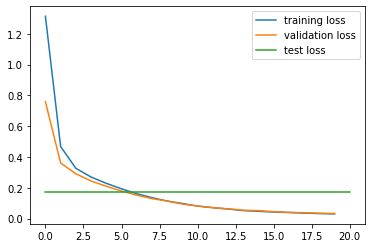

In [0]:
import matplotlib.pyplot as plt
plt.plot(results['train_loss'])
plt.plot(results['val_loss'])
plt.plot((0,20),(results['test_loss'],results['test_loss']))

plt.legend(['training loss', 'validation loss','test loss'])

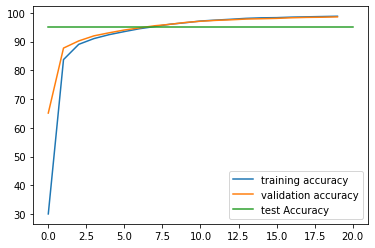

In [0]:
plt.plot(results['train_acc'])
plt.plot(results['val_acc'])
plt.plot((0,20),(results['test_acc'],results['test_acc']))
plt.legend(['training accuracy', 'validation accuracy','test Accuracy'])


# *****************   End of NoteBook *****************